<a href="https://colab.research.google.com/github/clachevv/neuro-match-project/blob/main/notebooks/pca_loaded_from_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# upload in file space all pca data inside a pca folder
# upload in file space video categories.csv

In [13]:
from google.colab import drive
drive.mount('/content/drive') # /content/drive/MyDrive/neuromatch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
# loading PCA data
train, test = {},{}
for i in range(8):
    train[f'layer_{i+1}'] = np.load(f"/content/drive/MyDrive/neuromatch/pca_100/train_layer_{i+1}.npy")
    test[f'layer_{i+1}'] = np.load(f"/content/drive/MyDrive/neuromatch/pca_100/test_layer_{i+1}.npy")

In [16]:
# this loads result from AlexNet Classification (with LLM reduction)
classes = pd.read_csv('/content/drive/MyDrive/neuromatch/video categories.csv', header=0)
classes['video_path'] = classes['video_id']
classes['video_id'] = classes['video_id'].str.split("/").str.get(3)
classes = classes[classes['index'] <= 1000]
classes['feat_index'] = classes['index'] + 1
dicty = classes[['feat_index',' llm_classes']]

In [17]:
filtered_train = {}
for layer, activation_weights in train.items():
    each_layer_df = pd.DataFrame(activation_weights).reset_index()
    each_layer_df['index'] = each_layer_df['index']+1
    each_layer_df.columns = ['feat_' + str(item) for item in each_layer_df.columns]
    filtered_layer = each_layer_df.merge(dicty, on = 'feat_index', how='right')
    filtered_train[layer] = filtered_layer

In [18]:
num_layers = 8  # number of layers in the model
layers = []

for i in range(num_layers):
  layers.append(f"layer_{i + 1}")

filtered_RDMs = {}
# create RDM for each layer from activations
for j, layer in enumerate(layers):
  maping_video_classes = dict(zip(filtered_train[layer].index, filtered_train[layer][' llm_classes']))
  activation_array = filtered_train[layer].drop(columns=['feat_index',' llm_classes']).to_numpy()
  filtered_RDMs[layer] = 1- np.corrcoef(activation_array)

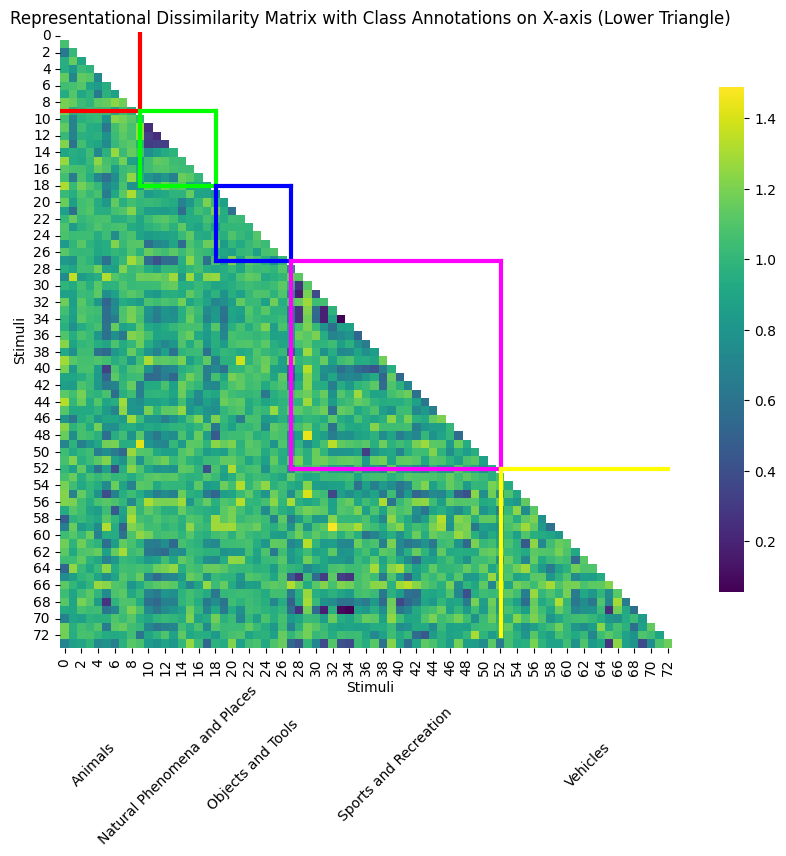

In [19]:
stimuli_classes = list(maping_video_classes.values())
rdm = filtered_RDMs['layer_3']
mask = np.triu(np.ones_like(rdm, dtype=bool))

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rdm, mask=mask, cmap='viridis', square=False, cbar_kws={"shrink": .82})

# Calculate class boundaries for annotation
unique_classes = list(pd.unique(stimuli_classes))
class_indices = {cls: [] for cls in unique_classes}
for idx, cls in enumerate(stimuli_classes):
    class_indices[cls].append(idx)

# Annotate the x-axis with a single label at the center of each class
for cls, indices in class_indices.items():
    middle = int(np.mean(indices))
    plt.text(middle, 88, cls, ha='center', va='center', fontsize=10, color='black', rotation=45, transform=plt.gca().transData)


plt.plot([9.5, 9.5], [9.5, 0], color=[1, 0, 0], linestyle='-', linewidth=3)     # animal
plt.plot([9.5, 0], [9.5, 9.5], color=[1, 0, 0], linestyle='-', linewidth=3)     # animal

plt.plot([9.55, 9.55], [18.55, 9.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([18.55, 9.55], [9.55, 9.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([9.55, 18.55], [18.55, 18.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places
plt.plot([18.55, 18.55], [9.55, 18.55], color=[0, 1, 0], linestyle='-', linewidth=3)     # natural phenomena and places

plt.plot([18.55, 18.55], [27.55, 18.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([27.55, 18.55], [18.55, 18.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([18.55, 27.55], [27.55, 27.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools
plt.plot([27.55, 27.55], [18.55, 27.55], color=[0, 0, 1], linestyle='-', linewidth=3)     # object and tools

plt.plot([27.55, 27.55], [52.55, 27.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([52.55, 27.55], [27.55, 27.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([27.55, 52.55], [52.55, 52.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation
plt.plot([52.55, 52.55], [27.55, 52.55], color=[1, 0, 1], linestyle='-', linewidth=3)     # sports and recreation

plt.plot([52.55, 52.55], [72.55, 52.55], color=[1, 1, 0], linestyle='-', linewidth=3)     # vehicles
plt.plot([72.55, 52.55], [52.55, 52.55], color=[1, 1, 0], linestyle='-', linewidth=3)     # vehicles

plt.xlabel('Stimuli')
plt.ylabel('Stimuli')
plt.title('Representational Dissimilarity Matrix with Class Annotations on X-axis (Lower Triangle)')
plt.show()

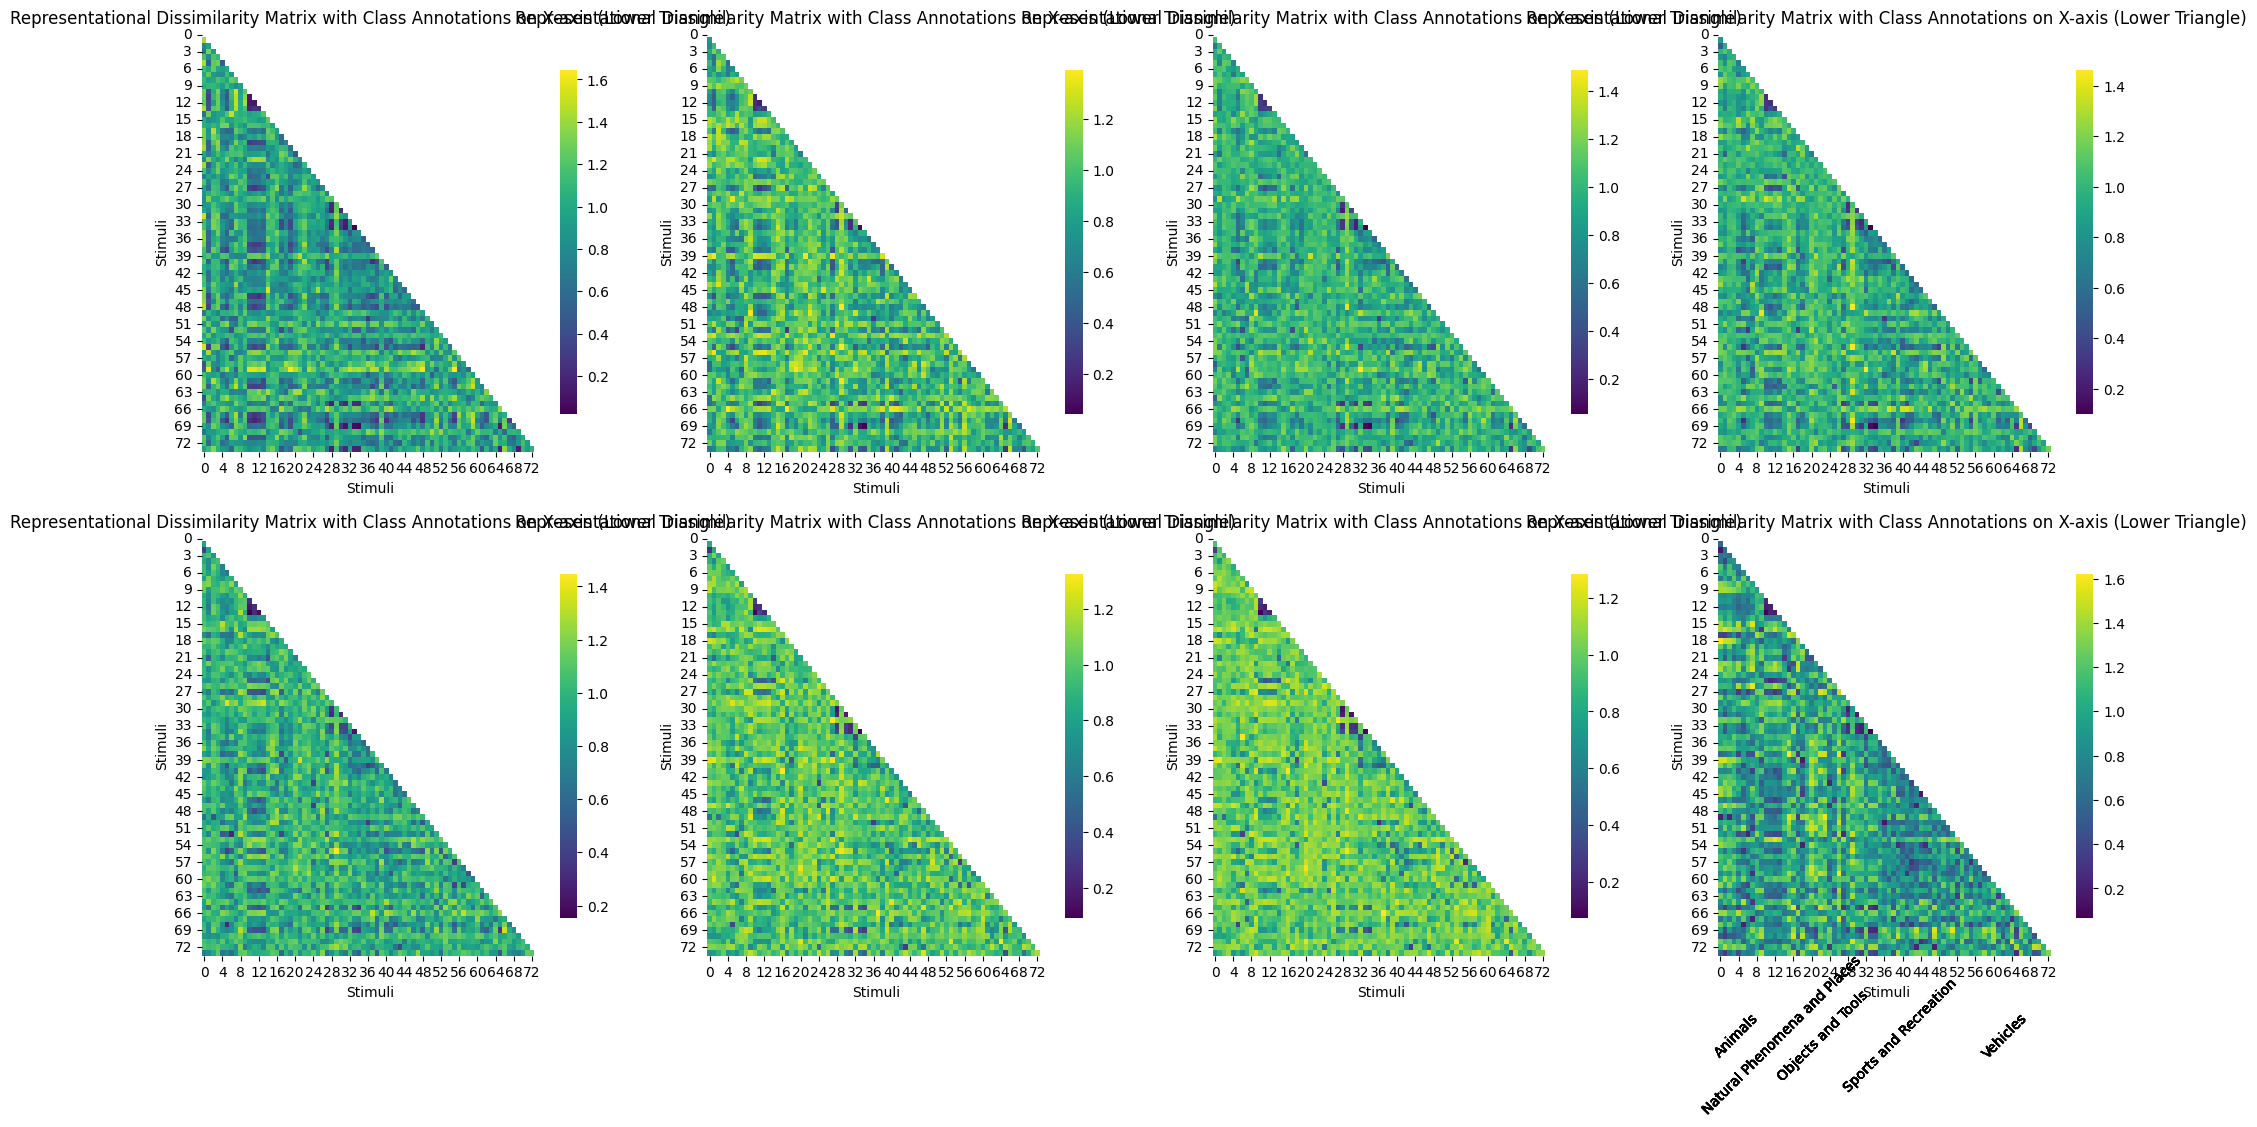

In [28]:
def create_rdm_plot(layer,ax):
    stimuli_classes = list(maping_video_classes.values())
    rdm = filtered_RDMs[layer]
    mask = np.triu(np.ones_like(rdm, dtype=bool))
    # RDM[np.triu_indices(RDM.shape[0], 1)] = np.nan

    # Create the heatmap
    sns.heatmap(rdm, mask=mask, cmap='viridis', square=False, cbar_kws={"shrink": .82}, ax=ax)

    # Calculate class boundaries for annotation
    unique_classes = list(pd.unique(stimuli_classes))
    class_indices = {cls: [] for cls in unique_classes}
    for idx, cls in enumerate(stimuli_classes):
        class_indices[cls].append(idx)

    # Annotate the x-axis with a single label at the center of each class
    for cls, indices in class_indices.items():
        middle = int(np.mean(indices))
        ax.text(middle, 88, cls, ha='center', va='center', fontsize=10, color='black', rotation=45, transform=plt.gca().transData)

    ax.set_xlabel('Stimuli')
    ax.set_ylabel('Stimuli')
    ax.set_title('Representational Dissimilarity Matrix with Class Annotations on X-axis (Lower Triangle)')
    # plt.show()

fig, axes = plt.subplots(2,4, figsize=(25,12))
axes = axes.flatten()
layers = [f'layer_{i}' for i in range(1,9)]
for ax,layer in zip(axes,layers):
    create_rdm_plot(layer,ax)


# def create_rdm_plot(maping_video_classes, rdm,ax):
#     stimuli_classes = list(maping_video_classes.values())
#     mask = np.triu(np.ones_like(rdm, dtype=bool))
#     sns.heatmap(rdm, mask=mask, cmap='viridis', square=False, cbar_kws={"shrink": .82}, ax=ax)

# fig, axes = plt.subplots(2,4, figsize=(25,12))
# axes = axes.flatten()
# layers = [f'layer_{i}' for i in range(1,9)]
# for ax,layer in zip(axes,layers):
#     rdm = filtered_RDMs[layer]
#     create_rdm_plot(maping_video_classes, rdm,ax)